# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 #opencv pour SIFT


pd.options.display.max_rows = 999

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from keras.preprocessing.image import load_img, img_to_array
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation
from keras.models import clone_model

from ipywidgets import IntProgress
from ipywidgets import Text
from IPython.display import display
from IPython.display import Image

from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL

import time

Using TensorFlow backend.
D:\Programs\envs\openclassrooms\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Programs\envs\openclassrooms\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Programs\envs\openclassrooms\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Programs\envs\openclassrooms\lib\site-packages\tensorflo

# Check memory

In [2]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
pd.DataFrame(sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

,0,1
0,Activation,1056
1,AgglomerativeClustering,1056
2,Conv2D,1056
3,CountVectorizer,1056
4,DBSCAN,1056
5,Dense,1056
6,Flatten,1056
7,GridSearchCV,1056
8,Image,1056
9,IntProgress,1056


# Préparation données

In [3]:
data = pd.read_csv('data_saved/data_categories.csv')

In [4]:
train = pd.read_csv('data_saved/train.csv')
test = pd.read_csv('data_saved/test.csv')

In [5]:
def get_files(path_list):
    '''Renvoie la liste des matrices d\'images à partir d'une liste de chemins'''
    liste_image = []
    compteur = 0
    for image_path in path_list:
        #im = cv2.imread(image_path, 0)
        im = np.array(Image_PIL.open(image_path))
        liste_image.append(im)
        compteur +=1
    
    del compteur
    del im
    
    return liste_image

In [6]:
def redim(array_im, width, height):
    '''Redimensionne l\'image correspondant à array_im dans la largeur et la hauteur définie'''
    min_x = 100000
    max_x = 0
    min_y = 100000
    max_y = 0
    shape = array_im.shape
    if shape[0] < min_x:
        min_x = shape[0]
    elif shape[0] > max_x:
        max_x = shape[0]
    if shape[1] < min_y:
        min_y = shape[1]
    elif shape[1] > max_y:
        max_y = shape[1]
    im = cv2.resize(array_im, dsize=(width,height))
    
    del shape
    
    return im

In [7]:
if False:
    train['image'] = train['image'].apply(lambda x: 'data/Images/'+str(x))
    test['image'] = test['image'].apply(lambda x: 'data/Images/'+str(x))

    train_cnn = get_files(train.copy()['image'].tolist())
    test_cnn = get_files(test.copy()['image'].tolist())

    train_array_cnn = np.vstack([redim(img, 224, 224).reshape(1,224,224,3) for img in train_cnn])
    test_array_cnn = np.vstack([redim(img, 224, 224).reshape(1,224,224,3) for img in test_cnn])
    del train_cnn, test_cnn
    #sauvegarde train_array_ccn / test_array_cnn
    np.save('data_saved/train_images_array', train_array_cnn)
    np.save('data_saved/test_images_array', test_array_cnn)
else:
    train_array_cnn = np.load('data_saved/train_images_array.npy')
    test_array_cnn = np.load('data_saved/test_images_array.npy')
    

In [8]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
array_cats = ohe.fit_transform(np.array(train['cat_lvl_2']).reshape(-1,1))

In [9]:
array_cats.todense().shape

(787, 57)

In [10]:
train_array_cats = ohe.transform(train[['cat_lvl_2']]).todense()
test_array_cats = ohe.transform(test[['cat_lvl_2']]).todense()

In [11]:
train_array_cats.shape

(787, 57)

In [12]:
test_array_cats.shape

(263, 57)

In [13]:
ohe.categories_[0].shape[0]

57

# Transfer Learning VGG16 Imagenet

In [14]:
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
vgg = VGG16()
vgg.layers.pop()
vgg.layers.pop()

vgg_transfer = Sequential()
vgg_transfer.add(vgg)
vgg_transfer.trainable = False
vgg_transfer.add(Dense(ohe.categories_[0].shape[0], activation='softmax'))
vgg_transfer.compile(loss='mean_squared_error', optimizer='sgd')


In [15]:
print('train array shape : ', train_array_cnn.shape)
print('train array cats : ', train_array_cats.shape)


train array shape :  (787, 224, 224, 3)
train array cats :  (787, 57)


In [16]:
#vgg_transfer.fit(train_array_cnn, train_array_cats, epochs=3, batch_size=20, verbose=1)

In [17]:
#vgg_transfer.save_weights('models/weighs_vgg_transfer.weights')

In [18]:
vgg_transfer.load_weights('models/weighs_vgg_transfer.weights')

In [108]:
train.iloc[36]

Unnamed: 0                                                                82
uniq_id                                     601817defaff9d0e30e1b72f96d3975f
crawl_timestamp                                    2016-03-10 07:45:58 +0000
product_url                http://www.flipkart.com/chinmay-kids-printed-c...
product_name                 CHINMAY KIDS Printed Cotton Padded Mosquito Net
pid                                                         MNTEGKSZD2ZWUBZK
retail_price                                                            1490
discounted_price                                                         540
image                                   601817defaff9d0e30e1b72f96d3975f.jpg
is_FK_Advantage_product                                                False
description                Specifications of CHINMAY KIDS Printed Cotton ...
product_rating                                           No rating available
overall_rating                                           No rating available

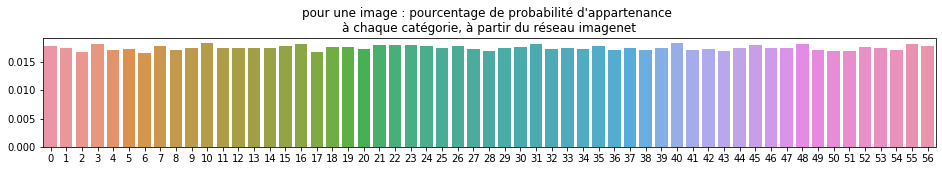

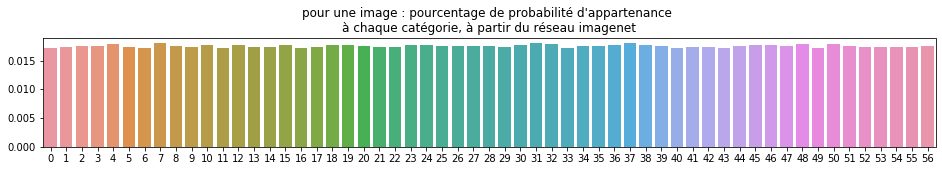

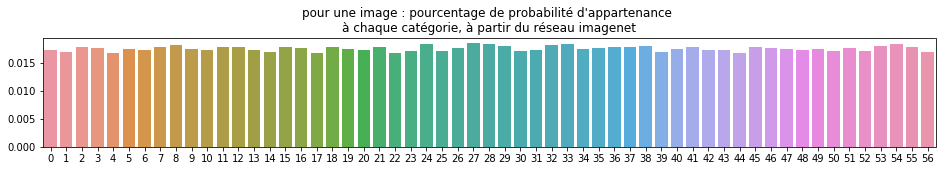

In [19]:
%matplotlib inline
ex_prediction_vgg = vgg_transfer.predict(redim(test_array_cnn[24], 224, 224).reshape(1,224,224,3))
plt.figure(figsize=(16,2))
plt.title('pour une image : pourcentage de probabilité d\'appartenance \nà chaque catégorie, à partir du réseau imagenet')
sns.barplot(x = list(range(ex_prediction_vgg.shape[1])), 
            y = ex_prediction_vgg[0])
plt.show()
ex_prediction_vgg = vgg_transfer.predict(redim(test_array_cnn[28], 224, 224).reshape(1,224,224,3))
plt.figure(figsize=(16,2))
plt.title('pour une image : pourcentage de probabilité d\'appartenance \nà chaque catégorie, à partir du réseau imagenet')
sns.barplot(x = list(range(ex_prediction_vgg.shape[1])), 
            y = ex_prediction_vgg[0])
plt.show()
ex_prediction_vgg = vgg_transfer.predict(redim(test_array_cnn[36], 224, 224).reshape(1,224,224,3))
plt.figure(figsize=(16,2))
plt.title('pour une image : pourcentage de probabilité d\'appartenance \nà chaque catégorie, à partir du réseau imagenet')
sns.barplot(x = list(range(ex_prediction_vgg.shape[1])), 
            y = ex_prediction_vgg[0])
plt.show()

In [20]:
vgg_train_output = vgg_transfer.predict(train_array_cnn)
vgg_test_output = vgg_transfer.predict(test_array_cnn)

In [21]:
vgg_train_output.shape

(787, 57)

In [22]:
vgg_test_output.shape

(263, 57)

In [23]:
vgg_output = np.vstack([vgg_train_output, vgg_test_output])

In [24]:
vgg_output.shape

(1050, 57)

In [25]:
np.save('data_saved/transfer_learning_output', vgg_output)

# Approche combinée

## Données

In [55]:
X_NLP = np.load('data_saved/X_reduce_NLP.csv.npy')
X_descripteurs = np.load('data_saved/array_features_descripteurs.npy')
X_CNN = np.load('data_saved/transfer_learning_output.npy')

In [56]:
X_NLP.shape

(1050, 340)

In [57]:
np.vstack([np.array(train['discounted_price']).reshape(-1,1),
           np.array(test['discounted_price']).reshape(-1,1)])

array([[  349.],
       [ 5436.],
       [13500.],
       ...,
       [  356.],
       [  550.],
       [  950.]])

In [58]:
np.array(data['discounted_price']).reshape(-1,1).shape[1]

1

## Homogénisation des dimensions

In [59]:
print('NLP : ', X_NLP.shape)
print('Descripteurs : ', X_descripteurs.T.shape)
print('CNN : ', X_CNN.shape)

NLP :  (1050, 340)
Descripteurs :  (1050, 6)
CNN :  (1050, 57)


on a 651 dimensions pour la partie textuelle et 63 pour la partie visuelle

## Assemblage des données

In [60]:
X_combined = np.hstack([np.array(data['discounted_price']).reshape(-1,1), 
           X_NLP,
           X_CNN, 
           X_descripteurs.T])

In [61]:
X_combined.shape

(1050, 404)

In [62]:
np.nan_to_num(X_combined, 0)

array([[ 8.99000000e+02, -9.31024547e-01, -4.00919196e-01, ...,
         1.32806832e-02,  3.65134515e-03,  1.72432547e-03],
       [ 4.49000000e+02, -2.00369516e+00, -7.85943405e-01, ...,
         1.32016707e-02,  2.97864899e-03,  1.39117823e-03],
       [ 0.00000000e+00, -2.01107421e+00, -7.44949128e-01, ...,
         1.38177397e-02,  4.36937856e-03,  2.02838192e-03],
       ...,
       [ 1.44900000e+03, -1.53179757e+00, -5.03298259e-01, ...,
         1.27466395e-02,  3.04512493e-03,  1.23044208e-03],
       [ 1.33300000e+03, -2.04731912e+00, -6.81413036e-01, ...,
         1.30292233e-02,  3.84811591e-03,  1.82639936e-03],
       [ 5.95000000e+02, -2.07808798e+00, -7.43695601e-01, ...,
         1.29538495e-02,  3.89470346e-03,  1.89778244e-03]])

In [63]:
np.save('data_saved/X_combined', X_combined)

In [64]:
X_combined = np.load('data_saved/X_combined.npy')

## Catégorisation

In [65]:
dict_kmeans = {}
inertia = {}
max_clusters=80

f = IntProgress(min=0, max=max_clusters) # instantiate the bar
g = Text(value='')
display(f) # display the bar
display(g)

for k in range(1,max_clusters+1):
    kmeans = KMeans(n_clusters=k,
                   verbose=1,
                   random_state=0,
                   n_jobs=-1).fit(X_combined)
    inertia[k] = kmeans.inertia_
    dict_kmeans[k] = kmeans
    f.value = k # signal to increment the progress bar
    g.value =str(k)+'/'+str(max_clusters)

IntProgress(value=0, max=80)

Text(value='')

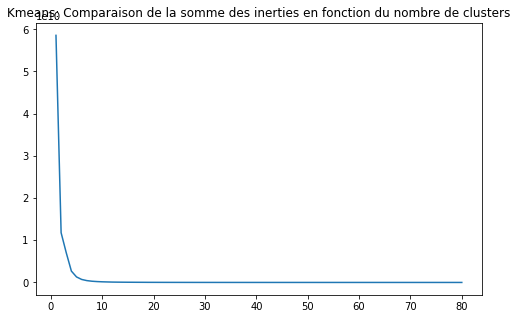

In [66]:
plt.figure(figsize=(8,5))
plt.title('Kmeans: Comparaison de la somme des inerties en fonction du nombre de clusters')
sns.lineplot(list(inertia.keys()),
             list(inertia.values())
            )

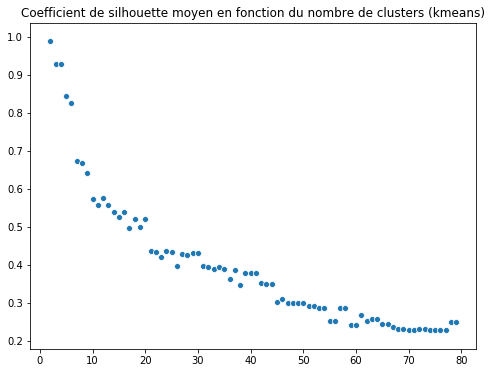

In [67]:

silhouettes_kmeans = {}
for i in range(2,max_clusters):
    silhouettes_kmeans[i] = silhouette_score(X = X_combined,
                                             labels= list(dict_kmeans[i].labels_))

plt.figure(figsize=(8,6)),
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
sns.scatterplot(x = list(silhouettes_kmeans.keys()),
               y = list(silhouettes_kmeans.values()))
plt.show()



In [68]:
for key, value in silhouettes_kmeans.items():
    if value == max(silhouettes_kmeans.values()):
        print('le coefficient de silhouette est maximal pour {} clusters (score = {})'.format(key, value))
        nb_clusters = key

le coefficient de silhouette est maximal pour 2 clusters (score = 0.9882808867943341)


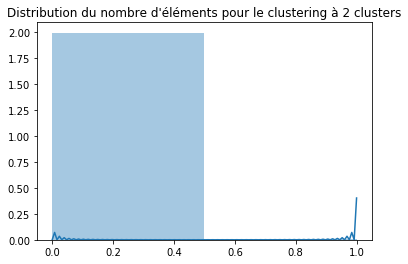

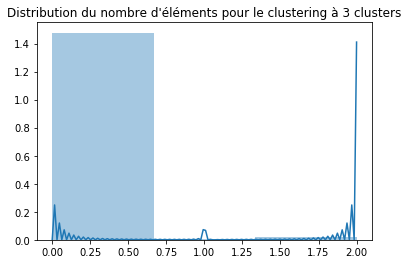

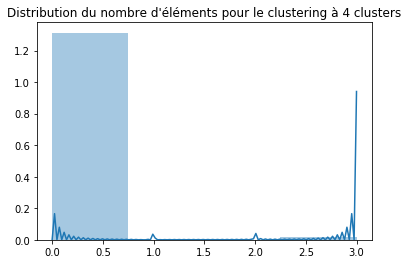

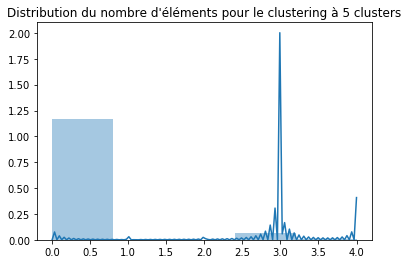

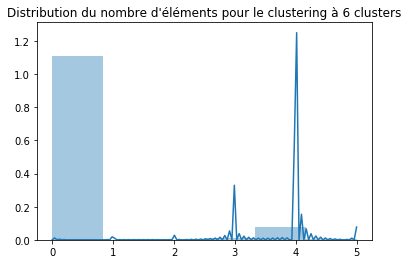

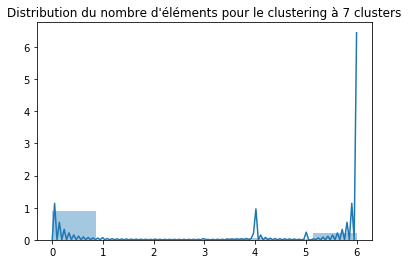

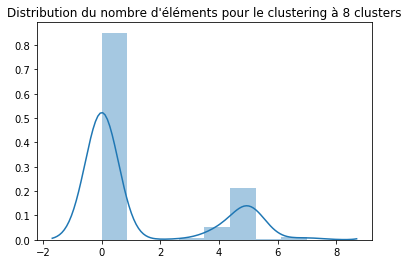

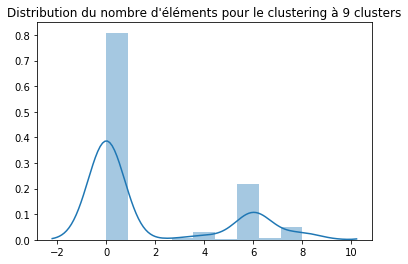

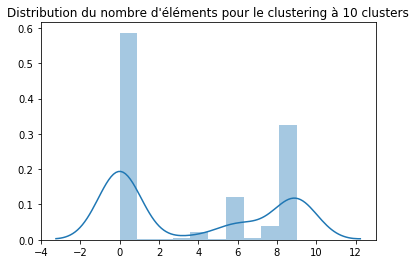

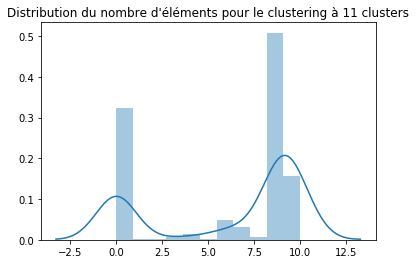

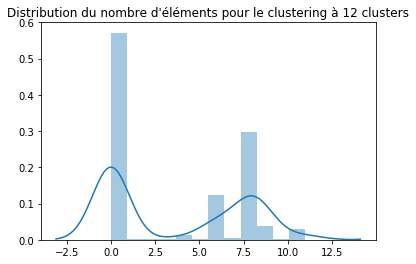

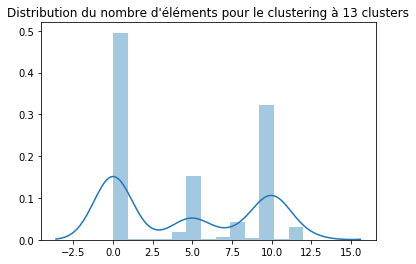

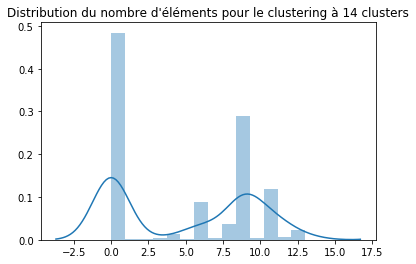

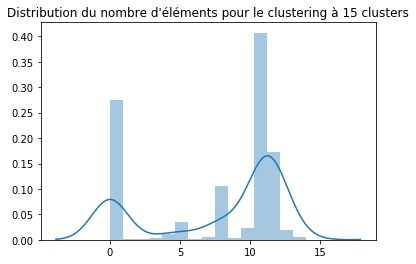

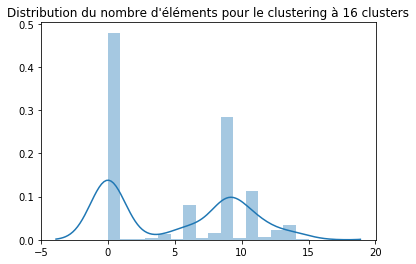

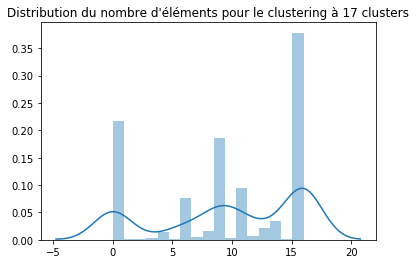

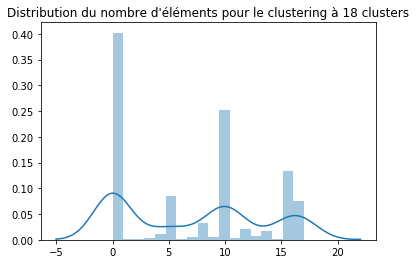

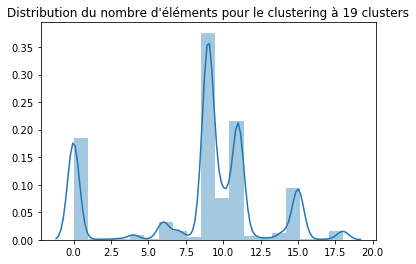

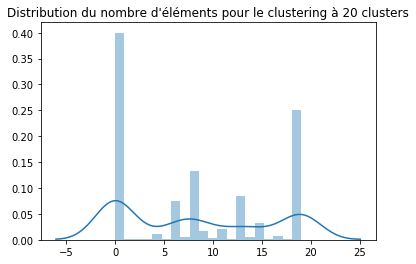

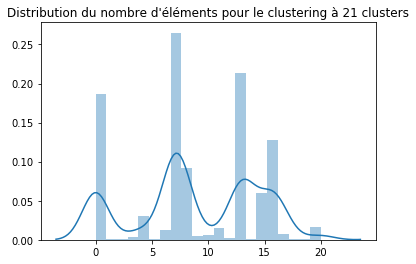

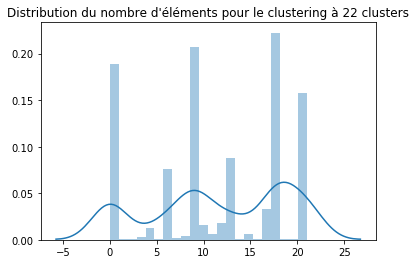

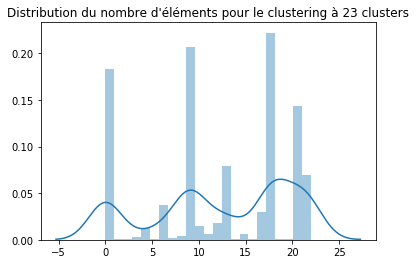

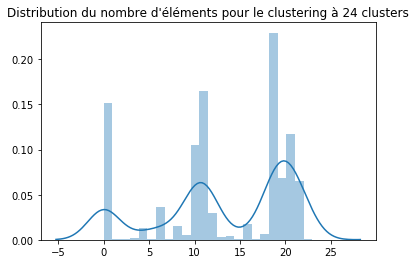

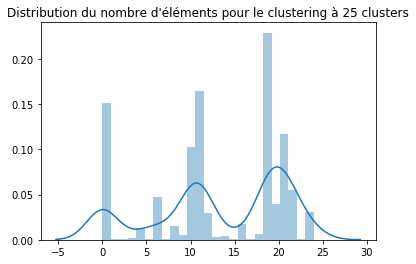

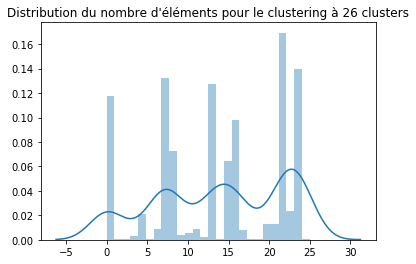

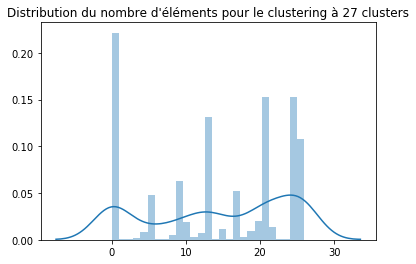

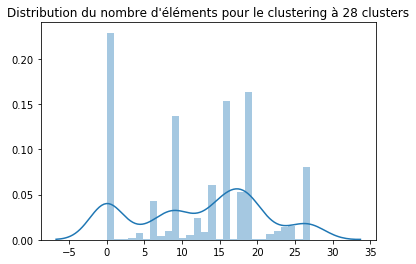

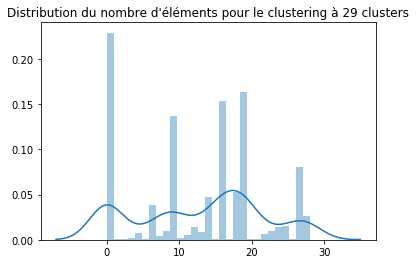

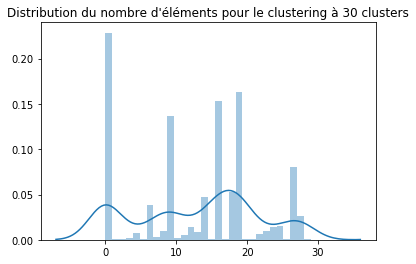

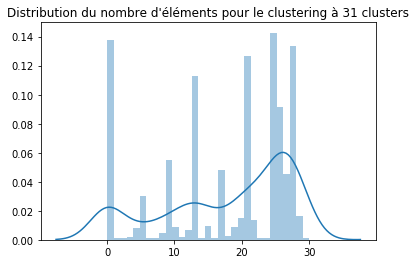

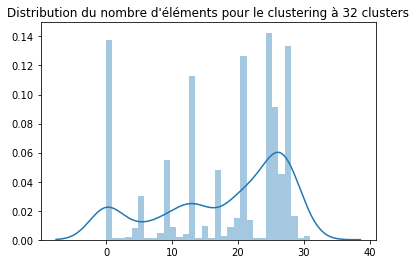

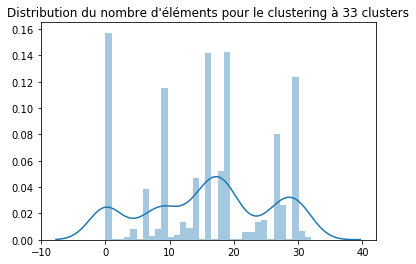

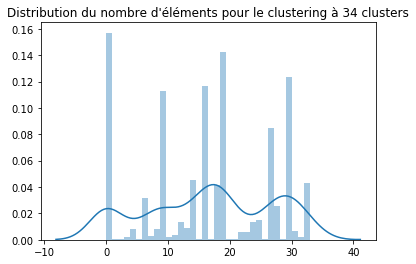

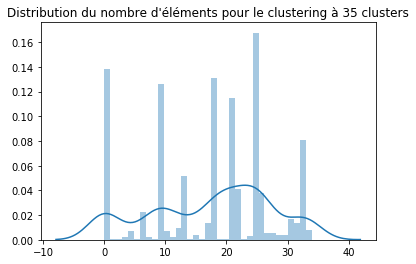

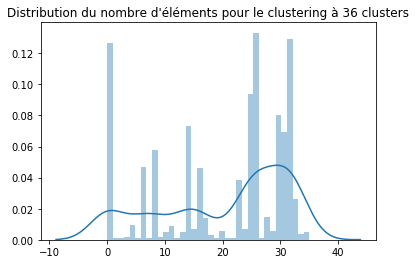

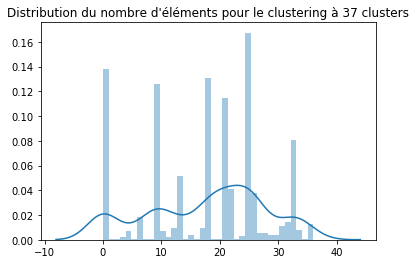

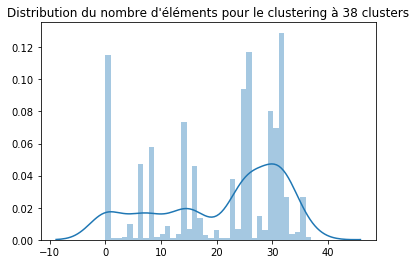

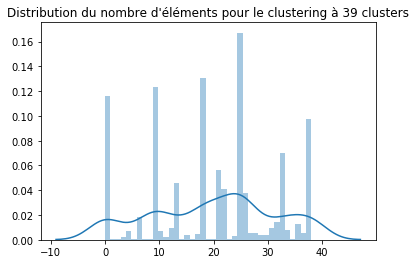

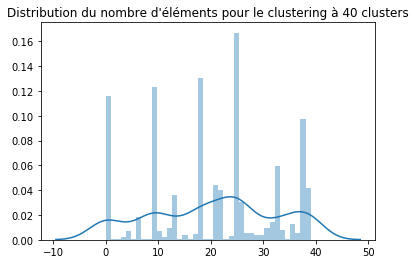

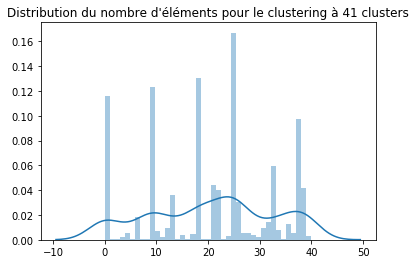

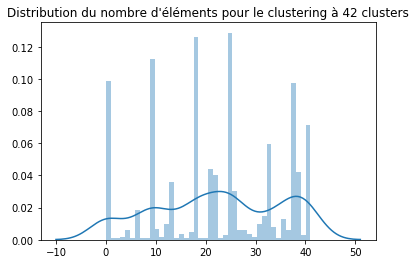

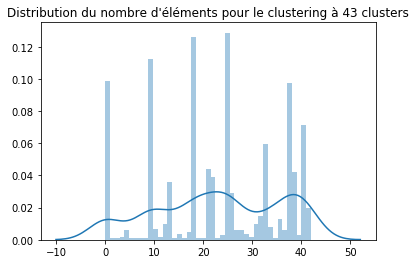

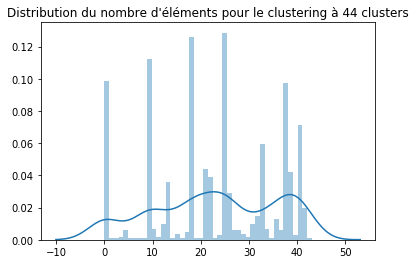

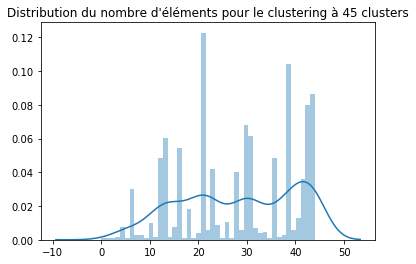

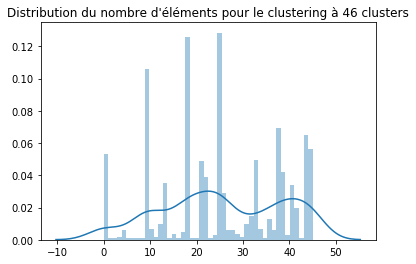

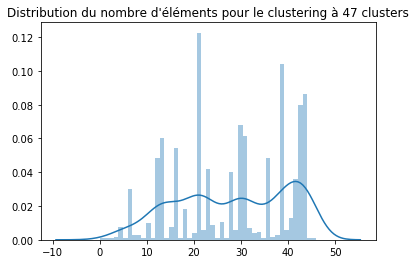

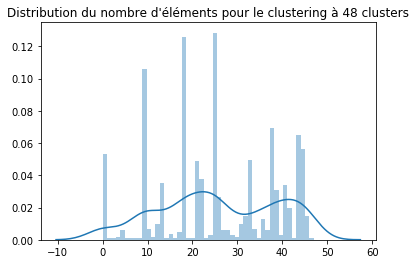

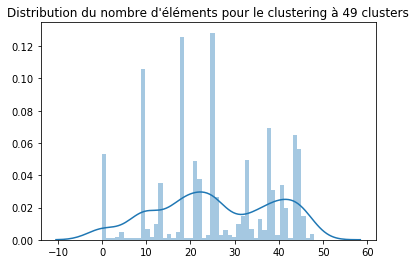

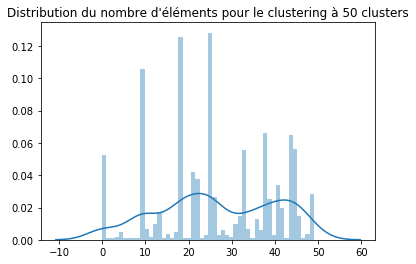

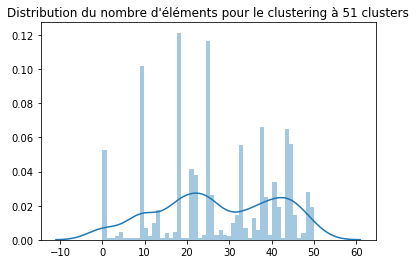

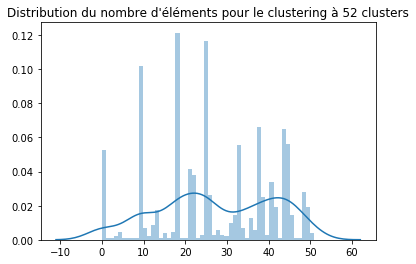

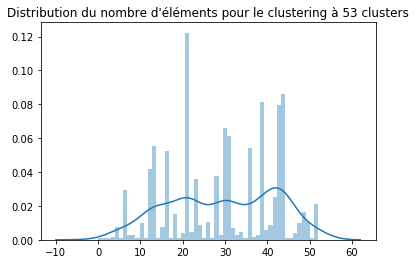

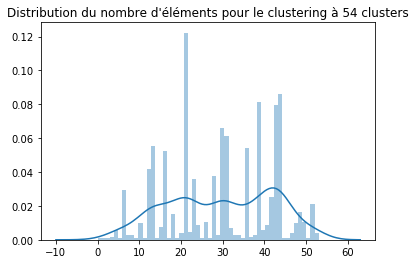

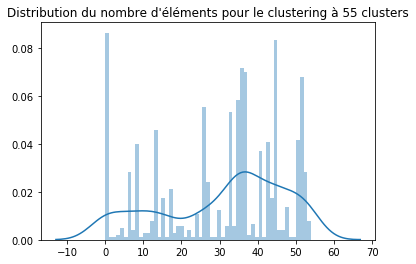

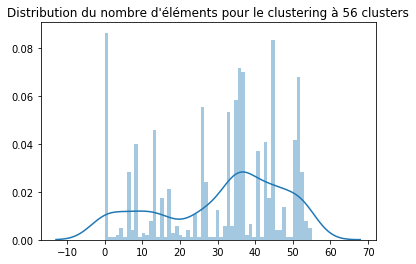

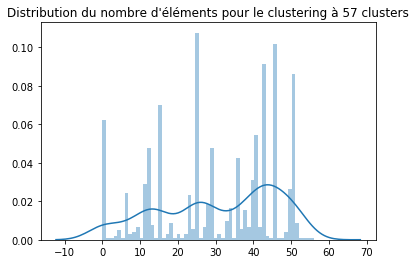

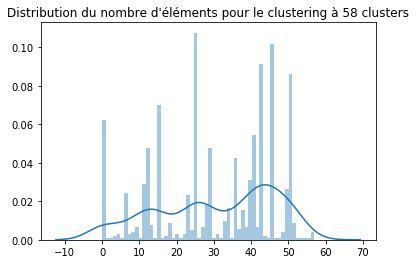

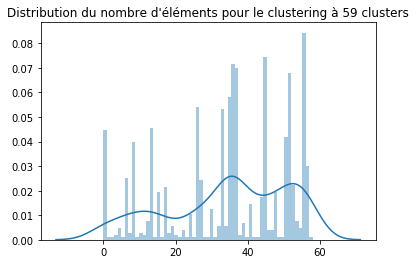

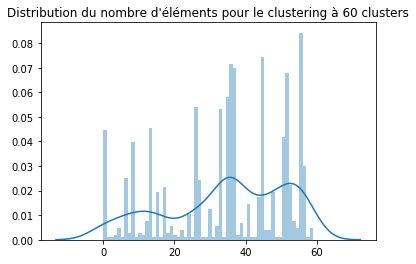

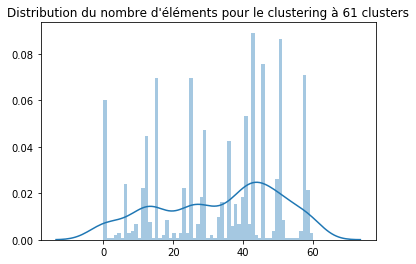

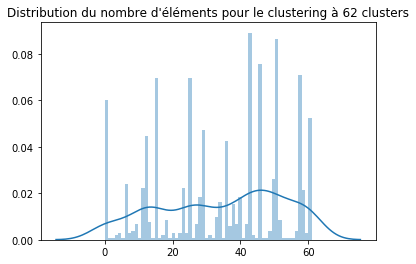

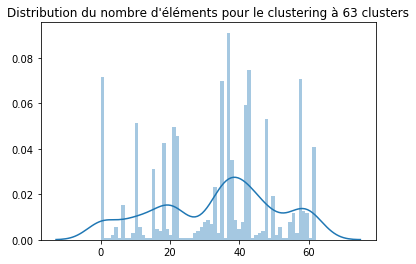

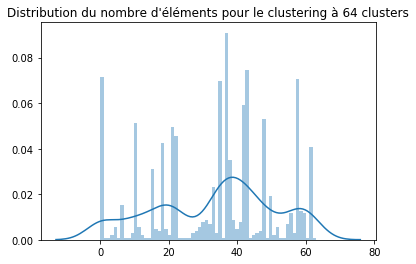

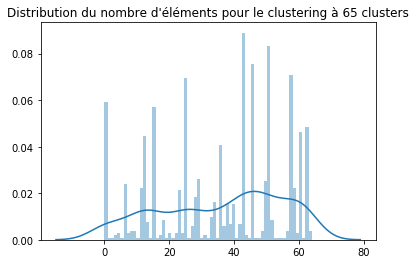

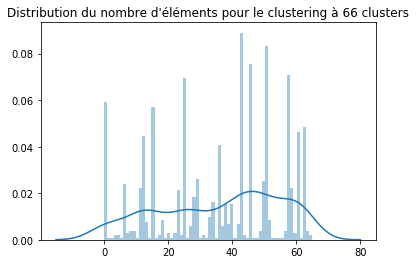

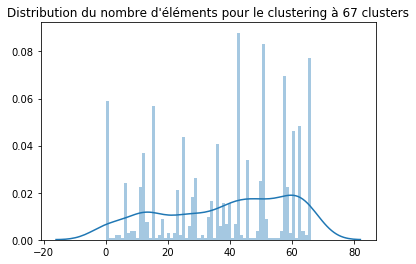

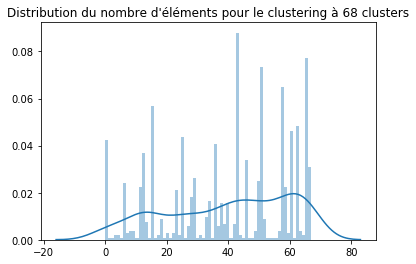

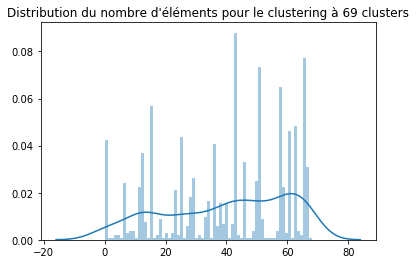

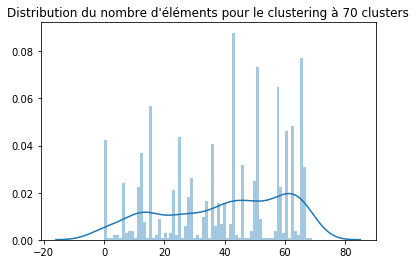

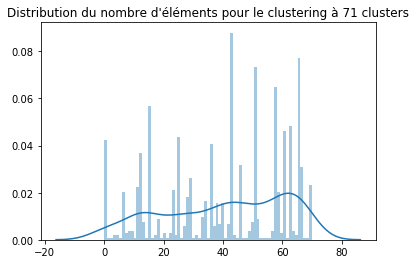

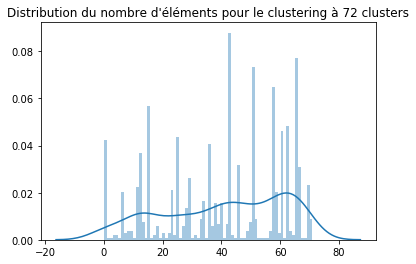

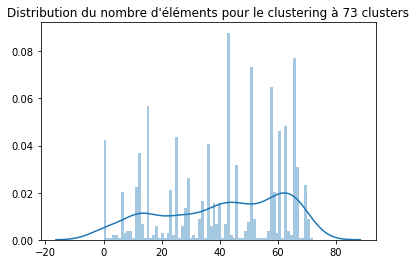

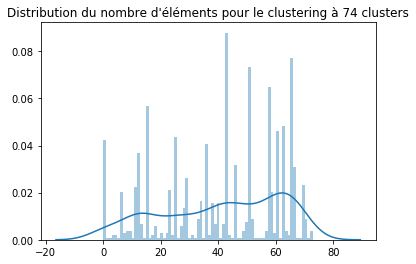

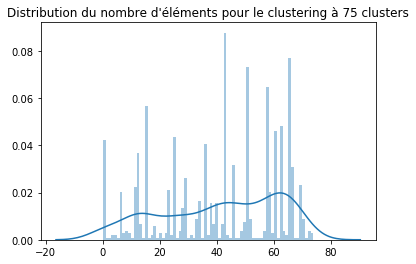

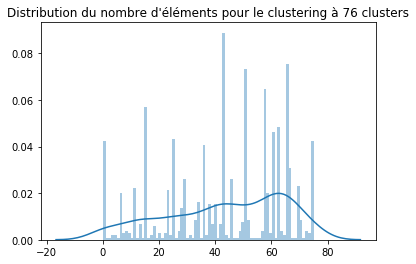

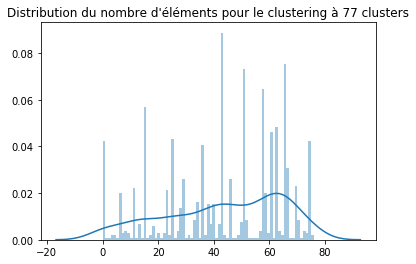

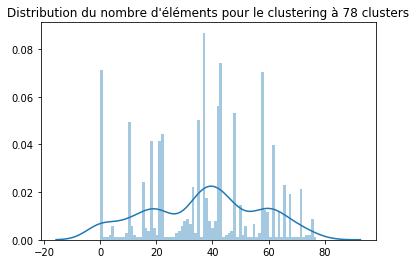

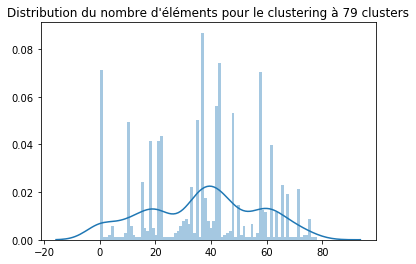

In [69]:
%matplotlib inline
for i in range(2,max_clusters):
    plt.figure()
    titre = 'Distribution du nombre d\'éléments pour le clustering à '+ str(i)+ ' clusters'
    plt.title(titre)
    sns.distplot(dict_kmeans[i].labels_, bins=i)
    plt.show()

Prenons le Kmeans avec 18 clusters

In [83]:
jeu_categoriel = pd.DataFrame(X_NLP)
jeu_categoriel['label'] = dict_kmeans[10].labels_

In [84]:
jeu_categoriel.to_csv('data_saved/jeu_complet_kmeans.csv')

In [85]:
jeu_categoriel.shape

(1050, 341)

## Représentation des données

In [86]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
T = tsne.fit_transform(X_combined.copy())

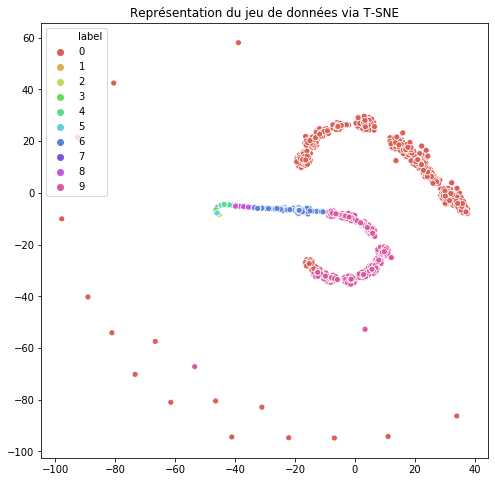

In [87]:
plt.figure(figsize=(8,8))
plt.title('Représentation du jeu de données via T-SNE')
palette_sns = sns.color_palette("hls", jeu_categoriel['label'].nunique())
sns.scatterplot(x= T[:,0], 
                y= T[:,1], 
                hue= jeu_categoriel['label'], 
                palette= palette_sns)

In [88]:
T.shape

(1050, 2)

In [89]:
X_combined.shape

(1050, 404)

In [90]:
data_final = pd.concat([train, test])
data_final['X_TSNE'] = T[:,0]
data_final['Y_TSNE'] = T[:,1]

In [91]:
data_final.set_index('Unnamed: 0', inplace=True)

In [92]:
data_final['label'] = jeu_categoriel['label'].tolist()

In [93]:
data_final.shape

(1050, 20)

In [94]:
data_final.to_csv('data_saved/data_final.csv')

In [95]:
data_final.head()

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cat_lvl_1,cat_lvl_2,cat_lvl_3,X_TSNE,Y_TSNE,label
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
165,785b4383b12106dd172306d427d8f7b2,2015-12-01 12:40:44 +0000,http://www.flipkart.com/rockmantra-cute-two-ca...,Rockmantra Cute Two Cats Ceramic Mug,MUGEAGGKFBTYPN4Z,499.0,349.0,785b4383b12106dd172306d427d8f7b2.jpg,False,Rockmantra Cute Two Cats Ceramic Mug (5.5 l)\r...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va...",Kitchen & Dining,Coffee Mugs,Rockmantra Coffee Mugs,6.238409,-29.466137,9
248,45d0af2c709de47268c80c35a117de44,2015-12-01 12:40:44 +0000,http://www.flipkart.com/malhar-niko-male-doll-...,Malhar Niko Male Doll Showpiece - 25 cm,SHIEY382SR75SXEY,6395.0,5436.0,45d0af2c709de47268c80c35a117de44.jpg,True,Buy Malhar Niko Male Doll Showpiece - 25 cm ...,No rating available,No rating available,Malhar,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Decor & Festive Needs,Showpieces,Malhar Showpieces,-5.952946,27.159256,0
310,64b463dc0b75ae40a848498c657041e6,2015-12-01 06:13:00 +0000,http://www.flipkart.com/linksys-smart-wi-fi-ro...,Linksys Smart Wi-Fi Router,RTRDZTF9DBT4CW8U,14999.0,13500.0,64b463dc0b75ae40a848498c657041e6.jpg,True,Buy Linksys Smart Wi-Fi Router only for Rs. 0....,No rating available,No rating available,Linksys,"{""product_specification""=>[{""key""=>""Encryption...",Computers,Network Components,Routers,37.652248,-8.064914,0
685,6b5cdfe68595fbcab0e05dc625d3d66a,2015-12-31 09:19:31 +0000,http://www.flipkart.com/richfeel-sunshield-spf...,Richfeel Sunshield - SPF 30 PA++,SNRE4F2GBWVF6UKR,299.0,224.0,6b5cdfe68595fbcab0e05dc625d3d66a.jpg,False,Flipkart.com: Buy Richfeel Sunshield - SPF 30 ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Quantity"",...",Beauty and Personal Care,Body and Skin Care,Face Care,-0.870694,-9.555494,9
843,e86daf9ebcdfc5c5dd088cdb7f8f8db6,2015-12-29 05:07:38 +0000,http://www.flipkart.com/epresent-mfan-1-fan-us...,Epresent Mfan 1 Fan USB USB Fan,USGEB3HTYWCYT2HY,269.0,219.0,e86daf9ebcdfc5c5dd088cdb7f8f8db6.jpg,False,Buy Epresent Mfan 1 Fan USB USB Fan for Rs.219...,No rating available,No rating available,Epresent,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Computers,Laptop Accessories,USB Gadgets,-12.526855,-30.653902,9
